<a href="https://colab.research.google.com/github/guillermodelafuente/IA3_projects/blob/main/EJERCICIO_Entornos_Guillermo_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**El objetivo del ejercicio es:**

- Optimizar arquitectura de la red

- Sacar heatmaps

- Partir training en training + validación usando como ejemplo lo que se hacía en el notebook de las caras (carpeta 03-caras)

In [2]:
COLAB = True

Si se desea ejecutar en local:

- Descargar el dataset de training de: https://drive.google.com/file/d/1cc5JyQvS4jJard7YsFKrYnHEcal0Bl6x

- Y el de test de: https://drive.google.com/file/d/1Gv5x1Y6K4JVLambfMBwGbDUDTC0xSQ2r

- Poner variable COLAB a False

In [3]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers
from keras import optimizers
from keras import models
from glob import glob

import matplotlib.pyplot as plt
import numpy as np

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

%matplotlib inline

In [4]:
!ls

sample_data


In [7]:
# loading best model 
from google.colab import files
model = files.upload()

In [8]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1cc5JyQvS4jJard7YsFKrYnHEcal0Bl6x',
                                        dest_path='./seg_train.zip', unzip=True)
    gdd.download_file_from_google_drive(file_id='1Gv5x1Y6K4JVLambfMBwGbDUDTC0xSQ2r',
                                        dest_path='./seg_test.zip', unzip=True)
    

Unzipping...Done.
Unzipping...Done.


In [9]:
!ls

__MACOSX  sample_data  seg_test  seg_test.zip  seg_train  seg_train.zip


In [10]:
!ls seg_train

buildings  forest  glacier  mountain  sea  street


In [11]:
!ls seg_test

buildings  forest  glacier  mountain  sea  street


In [12]:
!ls seg_train/buildings

0.jpg	   12578.jpg  14916.jpg  17468.jpg  20017.jpg  4600.jpg  7382.jpg
10006.jpg  12590.jpg  14918.jpg  17479.jpg  20027.jpg  4620.jpg  7383.jpg
10014.jpg  125.jpg    14947.jpg  17480.jpg  2002.jpg   4621.jpg  739.jpg
10018.jpg  12602.jpg  14952.jpg  17491.jpg  20048.jpg  4623.jpg  7418.jpg
1001.jpg   12615.jpg  14958.jpg  17495.jpg  20054.jpg  4630.jpg  742.jpg
10029.jpg  12617.jpg  14968.jpg  17503.jpg  2038.jpg   4631.jpg  7439.jpg
10032.jpg  12629.jpg  14984.jpg  17516.jpg  2041.jpg   4634.jpg  7443.jpg
10056.jpg  12632.jpg  14991.jpg  1751.jpg   2043.jpg   463.jpg	 7455.jpg
1009.jpg   12636.jpg  1501.jpg	 17520.jpg  2059.jpg   4667.jpg  7463.jpg
10113.jpg  1263.jpg   15026.jpg  17537.jpg  2069.jpg   4686.jpg  7471.jpg
10126.jpg  12649.jpg  15030.jpg  17539.jpg  2076.jpg   4715.jpg  7478.jpg
1012.jpg   12659.jpg  1503.jpg	 1753.jpg   2083.jpg   4748.jpg  747.jpg
10144.jpg  12668.jpg  15042.jpg  17541.jpg  2088.jpg   4770.jpg  7491.jpg
10151.jpg  12669.jpg  15045.jpg  17545.jpg  20

In [13]:
ficheros = glob("./seg_train/buildings/*")
ficheros[0]

'./seg_train/buildings/7185.jpg'

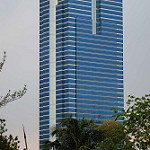

In [14]:
imagen = load_img(ficheros[1044])
imagen

In [15]:
imagen.size

(150, 150)

In [16]:
train_data_dir = 'seg_train'
validation_data_dir = 'seg_test'
test_data_dir = 'seg_test'

batch_size = 16

Para ver opciones:

https://keras.io/api/preprocessing/image/#imagedatagenerator-class


In [17]:
# data augmentation:

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

In [18]:
imagen_num = np.array([img_to_array(imagen)])

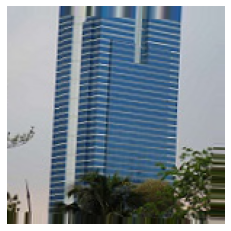

In [19]:
plt.imshow(train_datagen.flow(imagen_num)[0][0])
plt.axis("off");

In [20]:
# dimensiones a las que vamos a llevar las imágenes
img_width, img_height = 150, 150

normed_dims = (img_height, img_width)

In [21]:
normed_dims

(150, 150)

In [ ]:
# sparse_categorical_crossentropy

#building: 0
# 1,0,0,0,0,0

# forest': 1
# 0,1,0,0,0,0

# glacier: 2
# 0,0,1,0,0,0

# mountain: 3
# 0,0,0,1,0,0

# sea: 4,
# 0,0,0,0,1,0

# street: 5
# 0,0,0,0,0,1

# Transfer learning

In [33]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers
from tensorflow.keras import Model

In [23]:
#step1
pretrained_model=ResNet50( input_shape=(150,150,3),
                                  include_top=False,
                                  weights='imagenet'
                                   )

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
pretrained_model.summary()

In [25]:
#step2
for layer in pretrained_model.layers:
     layer.trainable = False

In [ ]:
pretrained_model.summary()

In [27]:
#step3        
last_layer = pretrained_model.get_layer('conv5_block3_out')
print('last layer of resnet50 : output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer of resnet50 : output shape:  (None, 5, 5, 2048)


In [37]:
#step4
x = layers.Flatten()(last_output)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(6, activation='softmax')(x)

In [56]:
#step5
model = Model(pretrained_model.input, x) 

In [57]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [70]:
#step6
model.compile(optimizer = optimizers.Adam(lr=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])


In [ ]:
#step7
#%%time
#with tf.device('/device:GPU:0'):
    # model_resnet.fit(x_train,y_train, epochs=20,validation_data=(x_test,y_test))

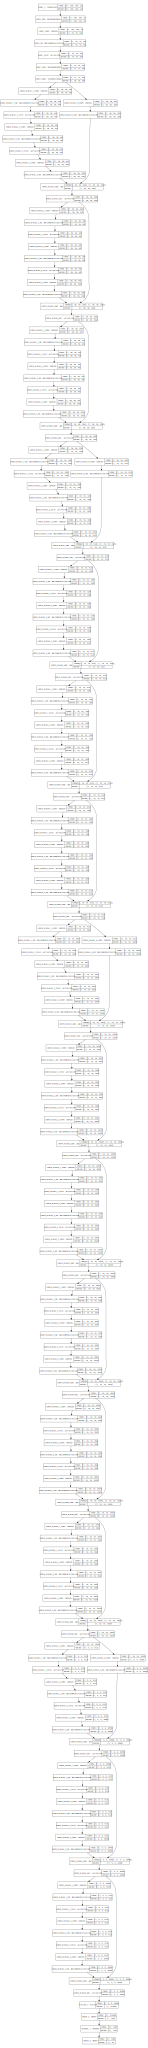

In [59]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

if COLAB:
    display(SVG(model_to_dot(model, show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg')))

In [60]:
preprocess_input = lambda x:x/255.

In [61]:
train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function = preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest',
    shear_range=0.01,
    zoom_range=0.1,
    horizontal_flip=True)

val_datagen  = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

test_datagen = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)

In [62]:
validation_data_dir, normed_dims

('seg_test', (150, 150))

In [63]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=True,
    class_mode='sparse')

validation_generator = val_datagen.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=batch_size,
    shuffle=False,
    class_mode='sparse')

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [64]:
test_datagen.flow_from_dataframe

<bound method ImageDataGenerator.flow_from_dataframe of <tensorflow.python.keras.preprocessing.image.ImageDataGenerator object at 0x7fc581ca4d68>>

In [65]:
train_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [66]:
number_train_samples = train_generator.n
number_val_samples   = validation_generator.n
number_test_samples  = test_generator.n

number_train_samples, number_val_samples, number_test_samples

(14034, 3000, 3000)

In [67]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [68]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
acum_tr_loss  = []
acum_val_loss = []

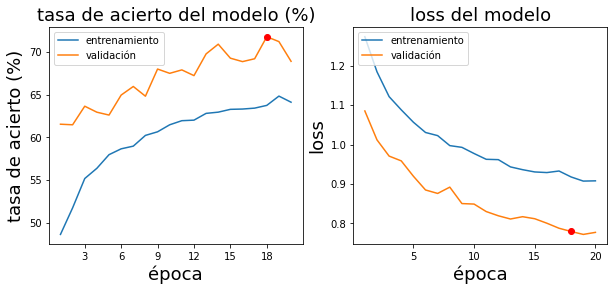

In [71]:
epochs = 20

modelpath="best_model_resnet.h5"

checkpoint = ModelCheckpoint(modelpath, monitor='val_accuracy', verbose=1,
                              save_best_only=True,
                              mode='max') # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]
for e in range(epochs):
    history = model.fit_generator(generator = train_generator, 
                                  steps_per_epoch=number_train_samples // batch_size,
                                  epochs=1,
                                  callbacks=callbacks_list,
                                  verbose=1,
                                  shuffle = True,
                                  validation_data=validation_generator,
                                  validation_steps=number_val_samples // batch_size
                                  )
    
    if history.history['val_accuracy'][-1] > best_val_acc:
        print("Validation accuracy improved from",
            best_val_acc, 'to', history.history['val_accuracy'])
        print("saving weights")
        best_val_acc = history.history['val_accuracy'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        best_i = np.argmax(acum_val_acc)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [72]:
!ls -la

total 423136
drwxr-xr-x 1 root root      4096 Dec 13 23:17 .
drwxr-xr-x 1 root root      4096 Dec 13 22:34 ..
-rw-r--r-- 1 root root 173529176 Dec 13 23:44 best_model_resnet.h5
drwxr-xr-x 1 root root      4096 Dec 10 17:17 .config
drwxr-xr-x 4 root root      4096 Dec 13 22:48 __MACOSX
drwxr-xr-x 1 root root      4096 Dec  2 22:04 sample_data
drwxr-xr-x 8 root root      4096 Dec 13 22:48 seg_test
-rw-r--r-- 1 root root  45638665 Dec 13 22:48 seg_test.zip
drwxr-xr-x 8 root root      4096 Dec 13 22:48 seg_train
-rw-r--r-- 1 root root 214084517 Dec 13 22:48 seg_train.zip


In [ ]:
#model = load_model(modelpath)
model = load_model('best_model.h5')

In [73]:
model

## **Resultados obtenidos**

In [ ]:
scores_tr = model.evaluate(train_generator)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(validation_generator)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(test_generator)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

878/878 [==============================] - 80s 91ms/step - loss: 0.3535 - accuracy: 0.1609
Train loss    : 0.3535119295120239
Train accuracy: 0.160894975066185

188/188 [==============================] - 4s 21ms/step - loss: 0.4409 - accuracy: 0.1460
Val loss    : 0.44091108441352844
Val accuracy: 0.1459999978542328

188/188 [==============================] - 4s 20ms/step - loss: 0.4409 - accuracy: 0.1460
Test loss     : 0.44091108441352844
Test accuracy : 0.1459999978542328


In [75]:
y_real = test_generator.classes
y_pred_proba = model.predict(test_generator)

In [76]:
y_real[:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [77]:
y_pred_proba[:5]

array([[7.4474740e-01, 3.1900760e-02, 1.8103211e-03, 1.1600859e-03,
        7.0641480e-02, 1.4974001e-01],
       [1.4085086e-01, 5.4978532e-01, 3.3684934e-03, 1.3064125e-03,
        7.5803394e-03, 2.9710853e-01],
       [8.4686589e-01, 6.0356245e-04, 5.2341563e-03, 6.4223381e-03,
        6.9567538e-03, 1.3391721e-01],
       [8.3886105e-01, 7.7485869e-04, 1.3878859e-03, 7.1994326e-04,
        1.8634917e-02, 1.3962130e-01],
       [2.1696633e-02, 5.6200144e-05, 2.8045893e-01, 5.4578173e-01,
        1.5025933e-01, 1.7472650e-03]], dtype=float32)

In [78]:
test_generator.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [79]:
num2class = {test_generator.class_indices[x]:x  for x in test_generator.class_indices.keys()}
num2class

{0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

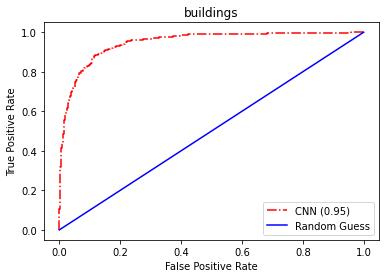

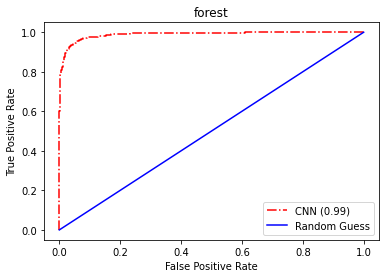

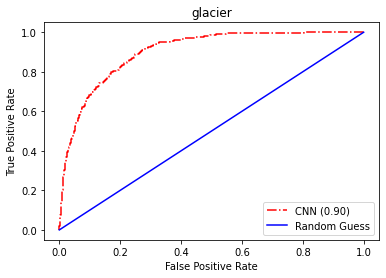

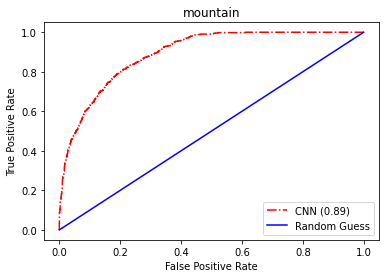

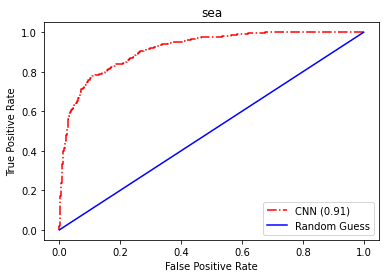

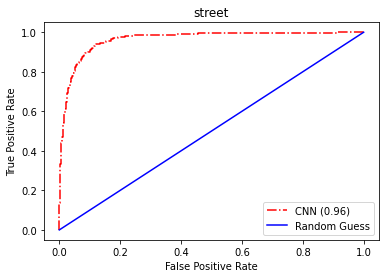

In [80]:
for clase in range(6):
    nombre_clase = num2class[clase]

    fpr, tpr, thresholds = roc_curve(y_real==clase, y_pred_proba[:,clase])
    fig, ax1 = plt.subplots(1,1)
    ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
    ax1.set_title(nombre_clase)
    ax1.legend()
    plt.show()

## **Visualización de ejemplos de test**

In [81]:
test_datagen2 = ImageDataGenerator(dtype='float32', preprocessing_function = preprocess_input)

test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n,
    shuffle=False,
    class_mode='sparse')

Found 3000 images belonging to 6 classes.


In [82]:
test_generator2.reset()
X_te, y_te = test_generator2.next()

In [83]:
test_generator2.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [84]:
y_te

array([0., 0., 0., ..., 5., 5., 5.], dtype=float32)

In [85]:
X_te.shape

(3000, 150, 150, 3)

In [86]:
X_te.max()

1.0

Clase real: glacier
buildings: 0% forest: 1% glacier: 6% mountain: 72% sea: 17% street: 0% 


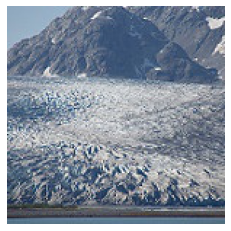

In [87]:
ind_te1 = 1333

image = X_te[ind_te1]

print("Clase real:", num2class[y_te[ind_te1]])
plt.imshow(image, cmap='jet')
plt.axis("off")
p = model.predict(preprocess_input(np.array([image])))[0]
cadena = ""
for i in range(len(num2class)):
    cadena = cadena + "{}: {}% ".format(num2class[i], int(100*p[i]))
print(cadena)

### Scores calculados a mano, cargando los 3 datasets a RAM:

In [ ]:
# Ahora para continuar haciendo mis cuentas cargo los datasets a RAM

train_datagen2 = ImageDataGenerator(dtype='float32',
                                    preprocessing_function = preprocess_input)
train_generator2 = train_datagen2.flow_from_directory(
    train_data_dir,
    target_size=normed_dims,
    batch_size=train_generator.n, # todas las imágnes del directorio test
    shuffle=False,
    class_mode='sparse')
train_generator2.reset()

val_datagen2 = ImageDataGenerator(dtype='float32',
                                  preprocessing_function = preprocess_input)
val_generator2 = val_datagen2.flow_from_directory(
    validation_data_dir,
    target_size=normed_dims,
    batch_size=validation_generator.n, # todas las imágnes del directorio test
    shuffle=False,
    class_mode='sparse')
val_generator2.reset()


test_datagen2 = ImageDataGenerator(dtype='float32',
                                   preprocessing_function = preprocess_input)
test_generator2 = test_datagen2.flow_from_directory(
    test_data_dir,
    target_size=normed_dims,
    batch_size=test_generator.n, # todas las imágnes del directorio test
    shuffle=False,
    class_mode='sparse')
test_generator2.reset()

X_train, y_train = train_generator2.next() # todos los datos de test en RAM
X_val, y_val = val_generator2.next() # todos los datos de test en RAM
X_te, y_te = test_generator2.next() # todos los datos de test en RAM

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [ ]:
print("Calculando predicciones en training")
probs_train = model.predict(train_generator2)
print("Calculando predicciones en validación")
probs_val   = model.predict(val_generator2)
print("Calculando predicciones en test")
probs_test  = model.predict(test_generator2)

In [ ]:
probs_train[:5]

In [ ]:
y_predicho_train = probs_train.argmax(axis=1)
y_predicho_val = probs_val.argmax(axis=1)
y_predicho_test = probs_test.argmax(axis=1)
y_predicho_train.shape, y_predicho_val.shape, y_predicho_test.shape

In [ ]:
# Mis scores calculados a mano:
(y_train == y_predicho_train).mean(), (y_val == y_predicho_val).mean(), (y_te == y_predicho_test).mean()

In [ ]:
!ls

In [ ]:
# Para descargar el modelo a local:

from google.colab import files
files.download('./best_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Visualization: Kernels


In [ ]:
weights = model.get_weights()
print(np.shape(weights))
for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

(10,)
shape of weights[0]:  (3, 3, 3, 16)
shape of weights[1]:  (16,)
shape of weights[2]:  (3, 3, 16, 32)
shape of weights[3]:  (32,)
shape of weights[4]:  (3, 3, 32, 64)
shape of weights[5]:  (64,)
shape of weights[6]:  (18496, 128)
shape of weights[7]:  (128,)
shape of weights[8]:  (128, 6)
shape of weights[9]:  (6,)


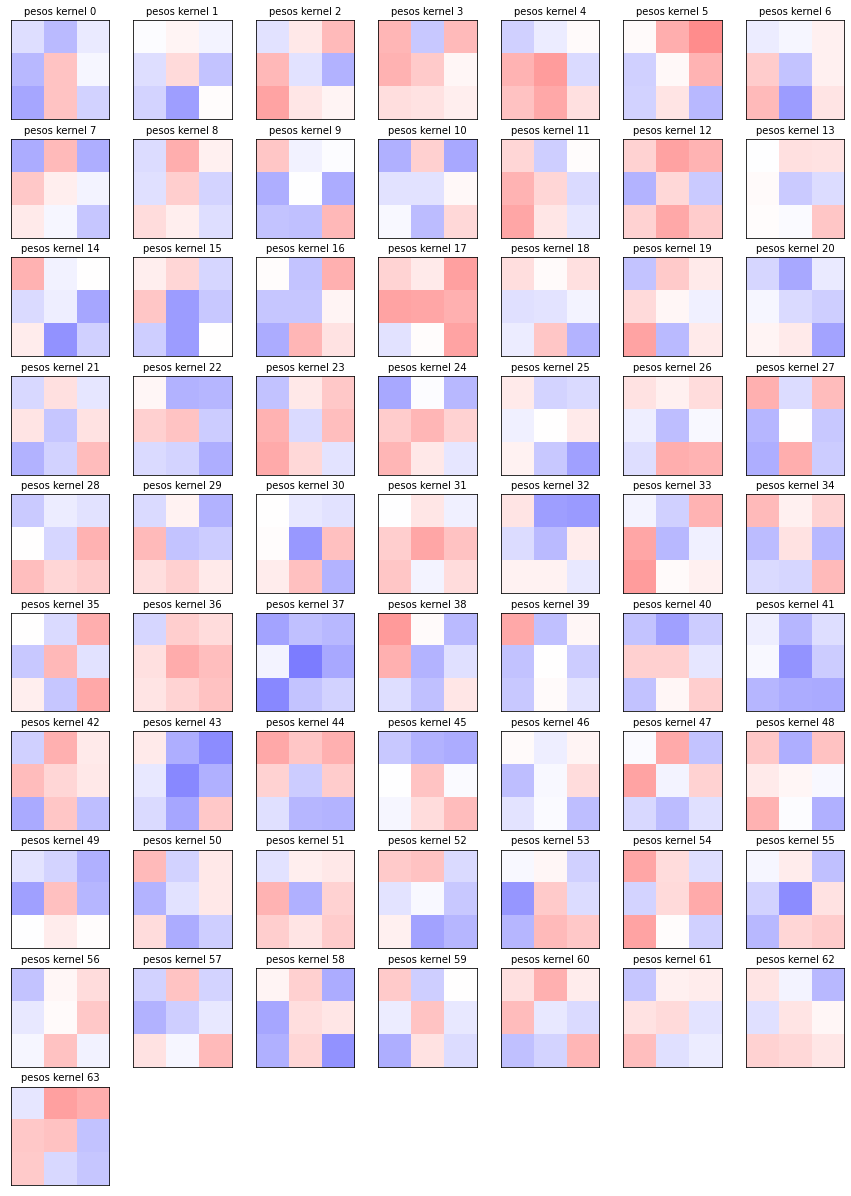

In [ ]:
# kernels de la primera capa convolucional
ncapa = 4

nfilters = weights[ncapa].shape[3]
ncols = 7 # número de columnas en la figura


ma = abs(weights[ncapa]).max()
nrows = int(np.ceil(nfilters/ncols)) # número de filas en la figura
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,15*nrows/ncols))
axes_r = axes.ravel()
for i in range(nfilters):
    kernel = weights[ncapa][:,:,2,i]
    ax = axes_r[i]
    ax.imshow(kernel, vmin=-ma, vmax=ma, cmap='bwr')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_title('pesos kernel %d' % i, fontsize=10)
for i in range(nfilters,nrows*ncols):
    fig.delaxes(axes_r[i])

## Visualization: OUTPUT - one-layer


Model: "functional_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6_input (InputLayer)  [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
Total params: 448
Trainable params: 448
Non-trainable params: 0
_________________________________________________________________





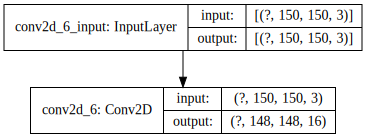

In [ ]:
# salida de una sola capa
ncapa = 0
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[ncapa].output)
intermediate_layer_model.summary()
print("\n\n")
if COLAB:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg')))
else:
    display(SVG(model_to_dot(intermediate_layer_model,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
imagen = X_te[1]
imagen.shape

(150, 150, 3)

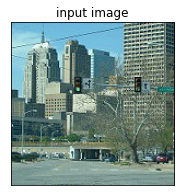

Salidas capa conv2d_6 (1, 148, 148, 16)


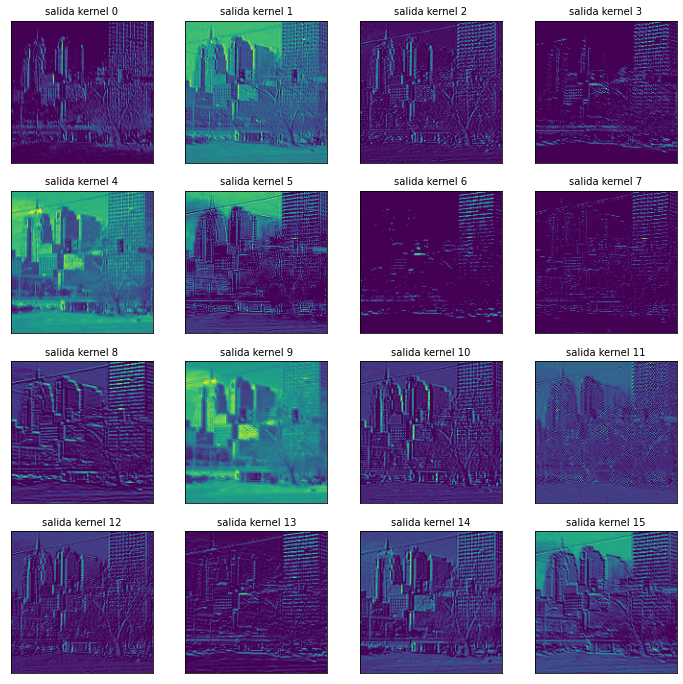

In [ ]:
ejemplo = 1

imagen = X_te[ejemplo]
aux = np.expand_dims(imagen, axis=0)
salida_capa = intermediate_layer_model.predict(aux)

plt.figure(figsize=(3,3))
plt.imshow(imagen, cmap='gray')  # IMPORTANT to divide by 255 if lambda x:x/255 is not used as preprocesion inpunt
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

print("Salidas capa "+intermediate_layer_model.layers[-1].name, salida_capa.shape)

nsalidas = salida_capa.shape[-1]
ncols = 4
nrows = int(np.ceil(nsalidas / ncols))

ma = abs(salida_capa).max()

plt.subplots(nrows,ncols,figsize = (12, 3*nrows))

for i in range(nsalidas):
    plt.subplot(nrows,ncols,i+1)
#    plt.imshow(salida_capa[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.imshow(salida_capa[0,:,:,i], cmap='viridis')
    plt.xticks(())
    plt.yticks(())
    plt.title('salida kernel %d' % i, fontsize=10)

## Visualization: OUTPUT multiple-layers

In [ ]:
# Now we extract the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model.layers[:6]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

activations = activation_model.predict(X_te[ejemplo:(ejemplo+1)])

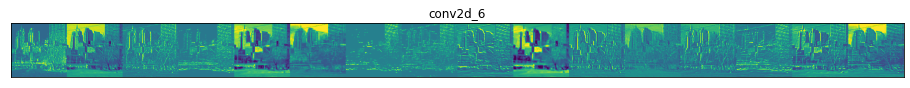

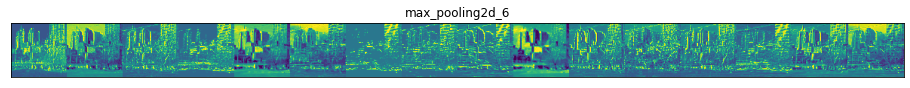

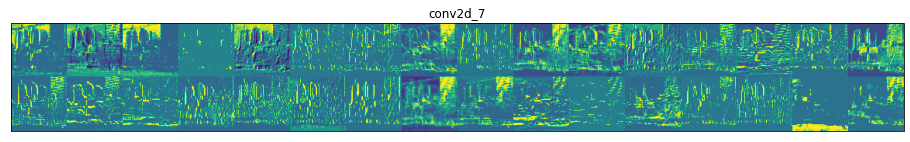

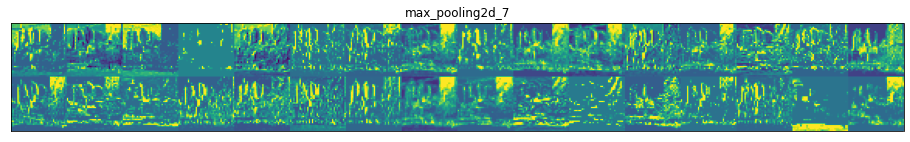

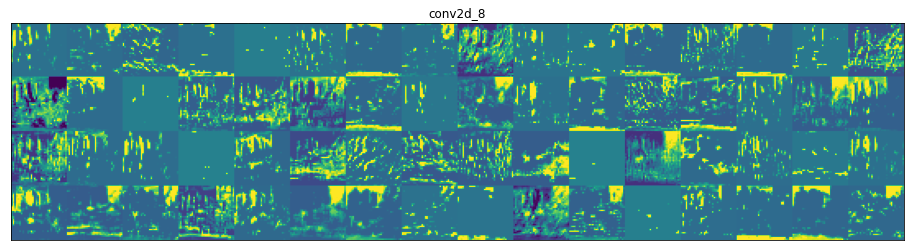

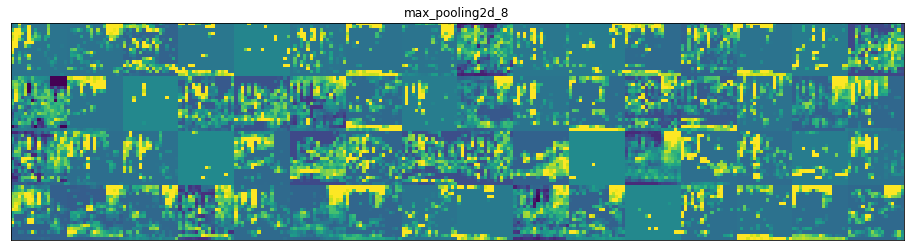

In [ ]:
# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

## Visualization: HEAT-MAP with Grad-CAM


In [88]:
class_indices = test_generator2.class_indices
class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [89]:
import tensorflow as tf
from keras import backend as K
import cv2

def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer


def show_heatmap(model, im):
    imag = np.expand_dims(im, axis=0) # de 1 imagen pasamos a 1 conjunto de 1 imagen
        
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    with tf.GradientTape() as tape:
        aux = model.output
        #aux = model.layers[-2].output # salida de la última capa densa antes de softmax

        iterate = tf.keras.models.Model([model.inputs], [aux, last_conv_layer.output])
        model_out, last_conv_layer = iterate(imag)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)

        # mean intensity of the gradient over a specific feature map channel:
        pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)    
    heatmap = np.maximum(heatmap, 0) # se quitan los negativos (se ponen a 0)
    heatmap /= np.max(heatmap) # se normaliza entre 0 y 1
    heatmap = heatmap[0] # pasamos de 1 conjunto de 1 heatmap a 1 heatmap
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) / 255
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_BONE) / 255
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT) / 255
    
    
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.5 + 0.5*im
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(im, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1); plt.xticks([]); plt.yticks([])
    plt.show()

    prob = 100*model.predict(imag)[0][class_indices["buildings"]] 
    print("Probabilidad clase buildings : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["forest"]] 
    print("Probabilidad clase forest : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["glacier"]] 
    print("Probabilidad clase glacier : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["mountain"]] 
    print("Probabilidad clase mountain : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["sea"]] 
    print("Probabilidad clase sea : {:2.1f}%".format(prob))
    prob = 100*model.predict(imag)[0][class_indices["street"]] 
    print("Probabilidad clase street : {:2.1f}%".format(prob))

    print("\n\n")
    return heatmap, superimposed_img

In [90]:
test_generator2.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

In [91]:
X_te[i].max()

1.0

In [92]:
len(X_te)

3000

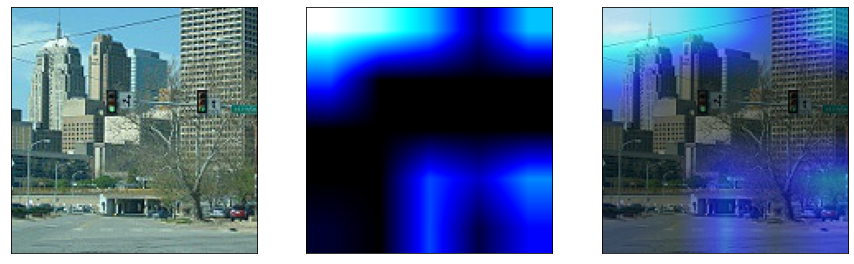

Probabilidad clase buildings : 14.1%
Probabilidad clase forest : 55.0%
Probabilidad clase glacier : 0.3%
Probabilidad clase mountain : 0.1%
Probabilidad clase sea : 0.8%
Probabilidad clase street : 29.7%





/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide


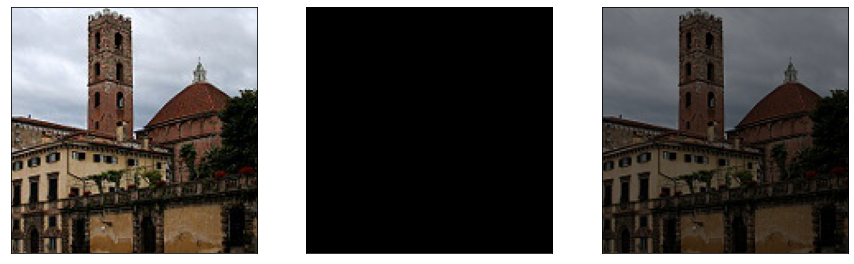

Probabilidad clase buildings : 84.7%
Probabilidad clase forest : 0.1%
Probabilidad clase glacier : 0.5%
Probabilidad clase mountain : 0.6%
Probabilidad clase sea : 0.7%
Probabilidad clase street : 13.4%





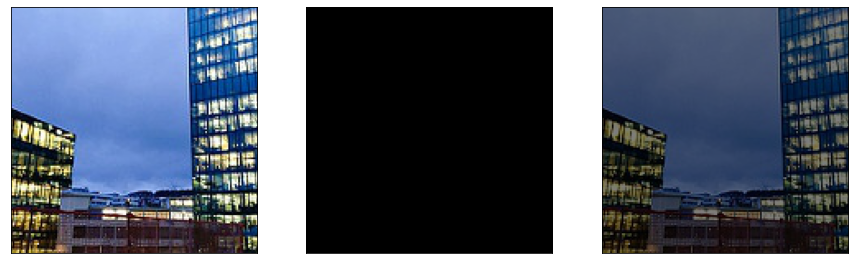

Probabilidad clase buildings : 83.9%
Probabilidad clase forest : 0.1%
Probabilidad clase glacier : 0.1%
Probabilidad clase mountain : 0.1%
Probabilidad clase sea : 1.9%
Probabilidad clase street : 14.0%





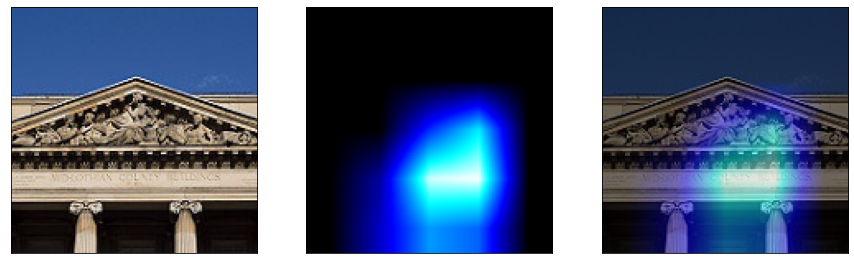

Probabilidad clase buildings : 2.2%
Probabilidad clase forest : 0.0%
Probabilidad clase glacier : 28.0%
Probabilidad clase mountain : 54.6%
Probabilidad clase sea : 15.0%
Probabilidad clase street : 0.2%





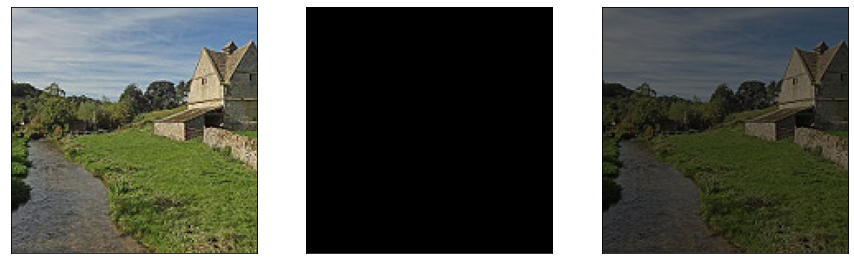

Probabilidad clase buildings : 2.7%
Probabilidad clase forest : 0.1%
Probabilidad clase glacier : 70.7%
Probabilidad clase mountain : 18.9%
Probabilidad clase sea : 2.6%
Probabilidad clase street : 5.1%





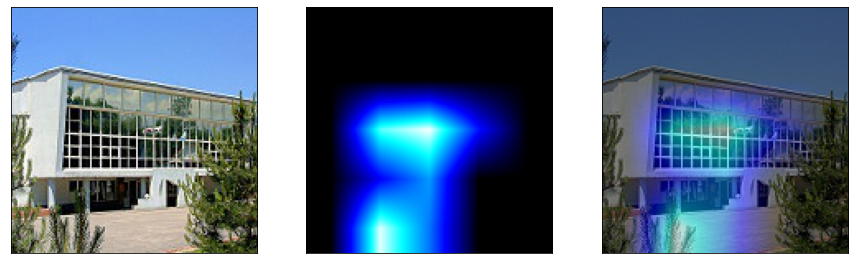

Probabilidad clase buildings : 93.6%
Probabilidad clase forest : 0.0%
Probabilidad clase glacier : 0.1%
Probabilidad clase mountain : 0.2%
Probabilidad clase sea : 4.4%
Probabilidad clase street : 1.7%





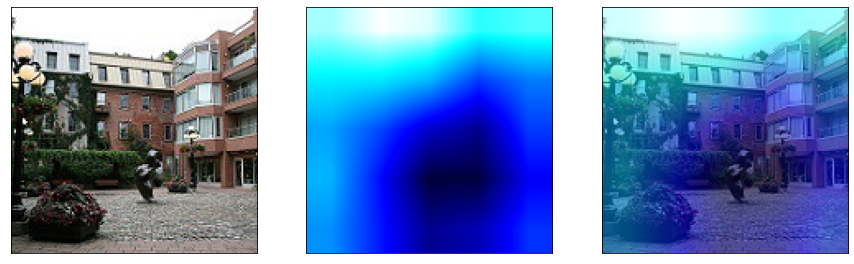

Probabilidad clase buildings : 21.6%
Probabilidad clase forest : 0.1%
Probabilidad clase glacier : 3.9%
Probabilidad clase mountain : 0.6%
Probabilidad clase sea : 1.9%
Probabilidad clase street : 72.0%





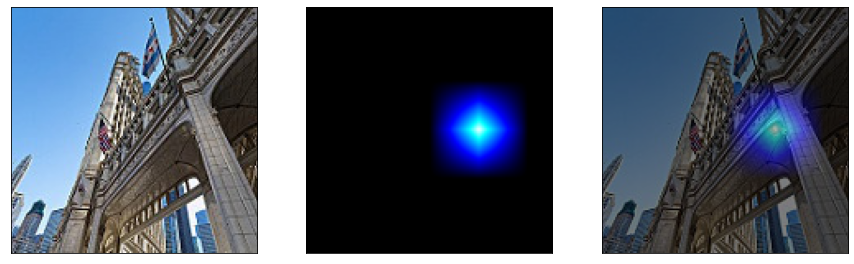

Probabilidad clase buildings : 66.6%
Probabilidad clase forest : 0.5%
Probabilidad clase glacier : 2.1%
Probabilidad clase mountain : 1.0%
Probabilidad clase sea : 0.4%
Probabilidad clase street : 29.4%





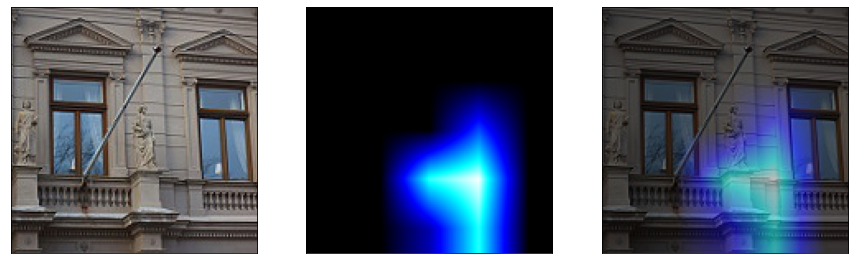

Probabilidad clase buildings : 67.6%
Probabilidad clase forest : 1.3%
Probabilidad clase glacier : 4.5%
Probabilidad clase mountain : 1.3%
Probabilidad clase sea : 3.7%
Probabilidad clase street : 21.6%





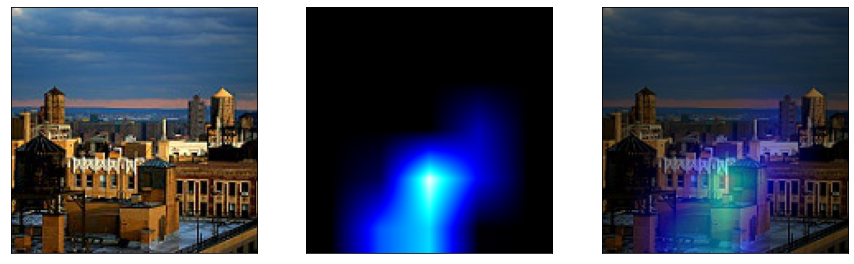

Probabilidad clase buildings : 47.4%
Probabilidad clase forest : 1.6%
Probabilidad clase glacier : 2.8%
Probabilidad clase mountain : 4.1%
Probabilidad clase sea : 10.2%
Probabilidad clase street : 33.8%





In [93]:
ind = 1

for i in range(ind, ind+10):
    show_heatmap(model, X_te[i])